Это одна из версий ноутбука (их несколько)

Я тщательно обдумывала, как лучше всего сформулировать цель (таргет) для нашей модели. Очевидный и, судя по результатам, наиболее эффективный подход — использовать данные из последнего заказа. Однако мне показалось не совсем корректным обучать модель на исторических данных о реальных покупках, предполагая, что некоторые из них не были совершены, и ставить в соответствующих случаях ноль.

Вместо этого, я решила использовать данные о всех совершенных покупках, отметив их как 1, и добавить в качестве нулей те товары (cart), которые пользователь не покупал. Чтобы определить, какие именно товары стоит добавить, я провела ассоциативный анализ с помощью алгоритма Apriori. Этот анализ помог выявить пары товаров, которые обычно покупаются вместе. На основании этих данных, я добавила соответствующие товары в корзину пользователя, выбрав для них ту же дату и время, что и для остальных товаров в заказе.

Такой способ показал более плохие результаты, тогда для увеличения числа нулей в таргете, я разбавила заказами рандомным образом, столько же, сколько и в заказе было едениц. 

итоговый результат получился лучше, но не значительно

Анализ данных был проведен, но не представлен

####  ДОП ФИЧИ

1. Среднее количество покупок пользователя в заказе
2. Частота заказов пользователя
3. Классификация пользователей по k-means
4. Ранжирование заказов, для придачи значимости самым частым и свежим покупкам
5. Все возможные временные фичи - день недели, час, месяц, год (категориальными типами)
6. Опередение черты пользователя как "выбор популярных товаров" и затем добавление ему в заказ популярных товаров если у него таких заказов много (было реализовано, но не представленно в этом репорте)
7. Предсказание времени следующего заказа, чтобы подготовить тестовый датасет

####  СТЕК И МЕТОДЫ

1. Из самых интересных - априори, алгоритм для выявления товаров,которые покупают вместе. Я использовала уже на предсказанных результатах. (как в рекомендательной системе комбинированного типа)
2. Cat Boost Classifier - удобно и быстро, можно было не масштабировать, но я масштабировала, кажется у меня модель переобучена, хотелось бы еще другие метрики посмотреть
3. Выявила топ самых покупаемых товаров и самых не покупаемых, чтобы улучшить итоговые предсказания

In [187]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [188]:
#pip install mlxtend

In [189]:
sample = pd.read_csv("/Users/boorzik/Documents/sbermarket/sbermarket-internship-competition/sample_submission.csv")
df = pd.read_csv("/Users/boorzik/Documents/sbermarket/sbermarket-internship-competition/train.csv")

найдем дату следующего заказа, чтобы построить предсказания для него


In [190]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

data_sorted = df.sort_values(by=['user_id', 'order_completed_at'])

In [191]:
# Рассчитываем временной интервал между заказами для каждого пользователя
data_sorted['next_order_diff'] = data_sorted.groupby('user_id')['order_completed_at'].diff().dt.days.shift(-1)

# Расчет среднего интервала времени между заказами для всех пользователей
mean_order_interval_all_users = data_sorted['next_order_diff'].mean()

# Заменяем нулевые и отрицательные значения интервала на средний интервал всех пользователей
data_sorted['next_order_diff'] = data_sorted['next_order_diff'].apply(lambda x: mean_order_interval_all_users if pd.isnull(x) or x <= 0 else x)

# Добавление информации о последней дате заказа для каждого пользователя
last_order_dates = data_sorted.groupby('user_id')['order_completed_at'].max().reset_index()
last_order_dates.rename(columns={'order_completed_at': 'last_order_date'}, inplace=True)

# Объединение средних интервалов и последних дат заказов
user_next_order_prediction = pd.merge(data_sorted.groupby('user_id')['next_order_diff'].mean().reset_index(), last_order_dates, on='user_id')

# Расчет предполагаемой даты следующего заказа
user_next_order_prediction['predicted_next_order_date'] = user_next_order_prediction['last_order_date'] + pd.to_timedelta(user_next_order_prediction['next_order_diff'], unit='D')

# Вывод предполагаемой даты следующего заказа для каждого пользователя
print(user_next_order_prediction[['user_id', 'predicted_next_order_date']])


       user_id     predicted_next_order_date
0            0 2020-09-04 07:59:12.286470875
1            1 2020-07-26 19:45:40.842687791
2            2 2020-06-30 20:50:44.403037860
3            3 2020-07-25 00:40:42.131284267
4            4 2020-09-14 07:55:55.870641035
...        ...                           ...
19995    19995 2020-08-31 17:02:14.109636154
19996    19996 2020-09-03 11:07:27.573775204
19997    19997 2020-09-01 13:53:01.109636154
19998    19998 2020-09-03 16:54:53.940200768
19999    19999 2020-09-01 22:13:02.109636154

[20000 rows x 2 columns]


округлим время

In [192]:
user_next_order_prediction['predicted_next_order_date'] = user_next_order_prediction['predicted_next_order_date'].round('1s')

In [193]:
user_next_order_prediction

,user_id,next_order_diff,last_order_date,predicted_next_order_date
0,0,2.014436,2020-09-02 07:38:25,2020-09-04 07:59:12
1,1,12.392163,2020-07-14 10:20:58,2020-07-26 19:45:41
2,2,12.096949,2020-06-18 18:31:08,2020-06-30 20:50:44
3,3,30.481402,2020-06-24 13:07:29,2020-07-25 00:40:42
4,4,17.750786,2020-08-27 13:54:48,2020-09-14 07:55:56
...,...,...,...,...
19995,19995,1.086552,2020-08-30 14:57:36,2020-08-31 17:02:14
19996,19996,1.140284,2020-09-02 07:45:27,2020-09-03 11:07:28
19997,19997,1.086552,2020-08-31 11:48:23,2020-09-01 13:53:01
19998,19998,1.077441,2020-09-02 15:03:23,2020-09-03 16:54:54


In [194]:
sample['user_id'] = sample['id'].apply(lambda x: int(x.split(';')[0]))
sample['cart'] = sample['id'].apply(lambda x: int(x.split(';')[1]))

In [195]:
# Объединение таблицы sample с предсказаниями дат следующих заказов
sample_with_predictions = pd.merge(sample, user_next_order_prediction[['user_id', 'predicted_next_order_date']], on='user_id', how='left')

print(sample_with_predictions.sample(10))


               id  target  user_id  cart predicted_next_order_date
4232       63;248       0       63   248       2020-09-05 05:22:24
214745   4162;379       0     4162   379       2020-09-05 03:32:26
24150     427;387       0      427   387       2020-09-08 19:30:35
252519    4899;92       0     4899    92       2020-08-15 03:59:12
696799   16723;15       0    16723    15       2020-08-24 09:17:30
313895   6258;419       1     6258   419       2020-08-21 12:05:32
390229    7978;25       0     7978    25       2020-09-04 03:21:58
615523  14103;384       1    14103   384       2020-08-30 16:53:59
310899   6184;380       1     6184   380       2020-08-22 14:24:34
633597   14619;10       0    14619    10       2020-09-01 01:53:44


Ассоциативный анализ, ищем с какими товарами обычно покупается тот или иной товар

In [196]:
# Группировка данных по заказам и агрегация категорий в списки
grouped = df.groupby(['user_id', 'order_completed_at'])['cart'].apply(list).reset_index(name='items')

# Создание списка транзакций
transactions = grouped['items'].tolist()

# Конвертация транзакций в формат, подходящий для mlxtend
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Находим часто покупаемые вместе товары с помощью алгоритма Apriori
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)  # Увеличиваем min_support

# Генерация ассоциативных правил
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)


# Выводим полученные правила
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


   antecedents consequents   support  confidence      lift
0         (57)        (14)  0.268455    0.516326  1.150757
1         (14)        (57)  0.268455    0.598316  1.150757
2         (61)        (14)  0.229774    0.525611  1.171452
3         (14)        (61)  0.229774    0.512107  1.171452
4        (398)        (14)  0.216785    0.555683  1.238475
5         (14)       (398)  0.216785    0.483157  1.238475
6         (57)        (22)  0.219793    0.422734  1.292722
7         (22)        (57)  0.219793    0.672128  1.292722
8         (57)        (23)  0.216116    0.415662  1.211661
9         (23)        (57)  0.216116    0.629982  1.211661
10        (57)        (61)  0.310712    0.597601  1.367021
11        (61)        (57)  0.310712    0.710759  1.367021
12        (57)        (84)  0.220175    0.423469  1.290503
13        (84)        (57)  0.220175    0.670974  1.290503
14        (57)       (398)  0.251994    0.484666  1.242343
15       (398)        (57)  0.251994    0.645935  1.2423

In [197]:
# Преобразование 'antecedents' и 'consequents' из frozenset в список для упрощения обработки
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])


In [198]:
#data_extended = pd.read_csv("/Users/boorzik/Documents/sbermarket/sbermarket-internship-competition/data_extended.csv")

In [199]:
data = pd.read_csv("/Users/boorzik/Documents/sbermarket/sbermarket-internship-competition/train.csv")

разбавим заказы нулями, то есть товарами, которых пользователь не заказывал

In [200]:
# Список всех уникальных товаров
all_items = data['cart'].unique()

# Функция для добавления случайных товаров в заказ, равное количеству товаров в заказе
def add_random_items(group, all_items):
    num_items = len(group)  # Количество товаров в текущем заказе
    existing_items = set(group['cart'])
    possible_items = list(set(all_items) - existing_items)
    random_items = np.random.choice(possible_items, min(num_items, len(possible_items)), replace=False)
    
    new_rows = []
    for item in random_items:
        new_row = {'user_id': group['user_id'].iloc[0], 
                   'order_completed_at': group['order_completed_at'].iloc[0], 
                   'cart': item, 
                   'target': 0}
        new_rows.append(new_row)
    
    return pd.concat([group, pd.DataFrame(new_rows)], ignore_index=True)

# Применение функции к каждому заказу и объединение результатов
new_data = pd.concat([add_random_items(group, all_items) for _, group in data.groupby(['user_id', 'order_completed_at'])]).reset_index(drop=True)

print(new_data)


         user_id   order_completed_at  cart  target
0              0  2020-07-19 09:59:17    20     NaN
1              0  2020-07-19 09:59:17    82     NaN
2              0  2020-07-19 09:59:17   441     NaN
3              0  2020-07-19 09:59:17    57     NaN
4              0  2020-07-19 09:59:17    14     NaN
...          ...                  ...   ...     ...
6246123    19999  2020-08-31 18:54:24   701     0.0
6246124    19999  2020-08-31 19:32:08   326     NaN
6246125    19999  2020-08-31 19:32:08    84     0.0
6246126    19999  2020-08-31 20:08:24   326     NaN
6246127    19999  2020-08-31 20:08:24   747     0.0

[6246128 rows x 4 columns]


In [201]:
new_data['target'] = new_data['target'].fillna(1)


In [202]:
new_data.target.value_counts()

target
1.0    3123064
0.0    3123064
Name: count, dtype: int64

Добавляем фичи


In [203]:
data = new_data.copy()

In [204]:
# Среднее количество покупок пользователя по всем категориям
user_purchase_counts = data.groupby('user_id')['cart'].count().reset_index(name='avg_purchases_per_user')
data = pd.merge(data, user_purchase_counts, on='user_id', how='left')

# Среднее количество уникальных категорий, купленных пользователем
user_unique_carts = data.groupby('user_id')['cart'].nunique().reset_index(name='avg_unique_carts_per_user')
data = pd.merge(data, user_unique_carts, on='user_id', how='left')


In [205]:
# Общее количество покупок по категориям
cart_purchase_counts = data.groupby('cart')['user_id'].count().reset_index(name='total_purchases_per_cart')
data = pd.merge(data, cart_purchase_counts, on='cart', how='left')


In [206]:
# Частота покупок конкретной категории пользователем
user_cart_interaction = data.groupby(['user_id', 'cart']).size().reset_index(name='user_cart_frequency')
data = pd.merge(data, user_cart_interaction, on=['user_id', 'cart'], how='left')


кластеризация пользователей


In [207]:
# Подготовка данных для кластеризации и масштабирование
features_for_clustering = ['avg_purchases_per_user', 'avg_unique_carts_per_user',  'user_cart_frequency']
X_clustering = data[features_for_clustering]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Кластеризация и добавление результатов как категориального признака
kmeans = KMeans(n_clusters=15, random_state=3146)
data['user_cluster'] = kmeans.fit_predict(X_scaled).astype(str)  # Преобразуем в строку для обозначения категориальности


# Указываем, что 'user_cluster' - категориальный признак
cat_features = ['user_cluster']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [208]:
data.user_cluster.value_counts()

user_cluster
13    1357369
2     1283579
11     957568
1      745482
7      471361
12     392264
6      302526
3      227469
4      140447
10     132528
8       83384
9       80795
0       35311
14      28792
5        7253
Name: count, dtype: int64

In [209]:
data['order_completed_at'] = pd.to_datetime(data['order_completed_at'])

# Определение даты начала интервала (последние полгода от максимальной даты в датасете)
start_date = data['order_completed_at'].max() - pd.DateOffset(months=6)

# Фильтрация данных за последние полгода
filtered_data = data[data['order_completed_at'] >= start_date]

# Агрегация данных для подсчета встречаемости каждой категории за последние полгода
category_counts_last_half_year = filtered_data['cart'].value_counts().reset_index(name='count')
category_counts_last_half_year.columns = ['cart', 'count']

# Выборка топ-80 самых популярных категорий за последние полгода
top_80_categories_last_half_year = category_counts_last_half_year.head(80)

print(top_80_categories_last_half_year)


    cart  count
0     57  78884
1     14  68839
2     61  67730
3    398  61249
4     23  52634
..   ...    ...
75   399  11712
76   441  11685
77    11  11578
78   377  11436
79   393  11012

[80 rows x 2 columns]


In [210]:

# Определение даты начала интервала (последние полгода от максимальной даты в датасете)
start_date = data['order_completed_at'].max() - pd.DateOffset(months=6)

# Фильтрация данных за последние полгода
filtered_data = data[data['order_completed_at'] >= start_date]

# Агрегация данных для подсчета встречаемости каждой категории за последние полгода
category_counts_last_half_year = filtered_data['cart'].value_counts().reset_index(name='count')
category_counts_last_half_year.columns = ['cart', 'count']

# Выборка 80 самых не популярных категорий за последние полгода
bottom_80_categories_last_half_year = category_counts_last_half_year.tail(80)

print(bottom_80_categories_last_half_year)


     cart  count
801   787   2511
802   827   2511
803   521   2511
804   319   2510
805   857   2510
..    ...    ...
876   459   2435
877   832   2425
878   321   2423
879   757   2422
880   195   2413

[80 rows x 2 columns]


In [211]:
# Назначаем ранг каждому заказу пользователя
data['order_rank'] = data.groupby('user_id')['order_completed_at'].rank("dense", ascending=True)

# Максимальный ранг в истории каждого пользователя
max_rank = data.groupby('user_id')['order_rank'].transform('max')

# Присваиваем 'target' нормализованное значение ранга
data['order_rank'] = data['order_rank'] / max_rank

In [212]:
data.columns

Index(['user_id', 'order_completed_at', 'cart', 'target',
       'avg_purchases_per_user', 'avg_unique_carts_per_user',
       'total_purchases_per_cart', 'user_cart_frequency', 'user_cluster',
       'order_rank'],
      dtype='object')

In [213]:
from sklearn.preprocessing import MinMaxScaler

# Названия столбцов для масштабирования, включая дату и новые признаки
columns_to_scale = [
       'avg_purchases_per_user', 'avg_unique_carts_per_user',
       'total_purchases_per_cart', 'user_cart_frequency',
       'order_rank']

# Создание и обучение масштабировщика
scaler = MinMaxScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Проверка результатов
print(data.head())


   user_id  order_completed_at  cart  target  avg_purchases_per_user  \
0        0 2020-07-19 09:59:17    20     1.0                0.011698   
1        0 2020-07-19 09:59:17    82     1.0                0.011698   
2        0 2020-07-19 09:59:17   441     1.0                0.011698   
3        0 2020-07-19 09:59:17    57     1.0                0.011698   
4        0 2020-07-19 09:59:17    14     1.0                0.011698   

   avg_unique_carts_per_user  total_purchases_per_cart  user_cart_frequency  \
0                   0.083524                  0.141759             0.000000   
1                   0.083524                  0.251831             0.005128   
2                   0.083524                  0.118062             0.005128   
3                   0.083524                  1.000000             0.010256   
4                   0.083524                  0.862990             0.005128   

  user_cluster  order_rank  
0           13    0.330189  
1           13    0.330189  
2    

In [214]:
data.columns

Index(['user_id', 'order_completed_at', 'cart', 'target',
       'avg_purchases_per_user', 'avg_unique_carts_per_user',
       'total_purchases_per_cart', 'user_cart_frequency', 'user_cluster',
       'order_rank'],
      dtype='object')

In [215]:
data = data.drop(['order_completed_at','total_purchases_per_cart'], axis = 1)

делим на тест и трейн

In [216]:

# Инициализация пустых списков для тренировочных и тестовых данных
train_data = []
test_data = []

# Группировка данных по 'user_id' и итерация по каждой группе
for _, group_data in data.groupby('user_id'):
    # Разделение данных каждого пользователя
    train_group, test_group = train_test_split(group_data, test_size=0.25, random_state=42)
    # Добавление в соответствующие списки
    train_data.append(train_group)
    test_data.append(test_group)

# Объединение всех тренировочных и тестовых групп в DataFrame
train_df = pd.concat(train_data).reset_index(drop=True)
test_df = pd.concat(test_data).reset_index(drop=True)

# Проверка результатов
print(f"Тренировочные данные: {train_df.shape}")
print(f"Тестовые данные: {test_df.shape}")


Тренировочные данные: (4679702, 8)
Тестовые данные: (1566426, 8)


In [217]:
pip install catboost


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=64763) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [218]:
# Разделение тренировочного набора данных на признаки и целевую переменную
X_train = train_df.drop(['target','user_id'], axis=1)
y_train = train_df['target']

# Если тестовый набор данных содержит целевую переменную
X_test = test_df.drop(['target','user_id'], axis=1)
y_test = test_df['target']

# Вывод размерности для проверки
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (4679702, 6), y_train: (4679702,)
X_test: (1566426, 6), y_test: (1566426,)


In [219]:
from catboost import Pool


In [220]:
# train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
# test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)


In [221]:
X_train['user_cluster'].dtype

dtype('O')

In [222]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [223]:
pip install ipywidgets

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=64763) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [224]:
from catboost import CatBoostClassifier, cv, Pool

# Подготовка данных
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 4,
    'eval_metric': 'F1',
    'loss_function': 'Logloss',  # Добавлен параметр loss_function
    'verbose': 200,
    # Указать другие параметры, если необходимо
}

# Кросс-валидация
cv_results = cv(pool=train_pool, params=params, fold_count=2, plot=True)

# После кросс-валидации можно обучить модель на всем обучающем наборе данных с лучшими параметрами
model = CatBoostClassifier(**params)
model.fit(train_pool)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]
0:	learn: 0.7812338	test: 0.7812109	best: 0.7812109 (0)	total: 478ms	remaining: 47.4s
99:	learn: 0.8823176	test: 0.8823170	best: 0.8823170 (99)	total: 47.3s	remaining: 0us

bestTest = 0.8823169728
bestIteration = 99

Training on fold [1/2]
0:	learn: 0.8168092	test: 0.8168355	best: 0.8168355 (0)	total: 563ms	remaining: 55.8s
99:	learn: 0.8816193	test: 0.8815932	best: 0.8815932 (99)	total: 50s	remaining: 0us

bestTest = 0.8815931807
bestIteration = 99

0:	learn: 0.7810416	total: 505ms	remaining: 50s
99:	learn: 0.8798972	total: 44.3s	remaining: 0us


In [225]:
data.target.value_counts()

target
1.0    3123064
0.0    3123064
Name: count, dtype: int64

In [226]:
# Получение важности признаков
feature_importances = model.get_feature_importance(train_pool)


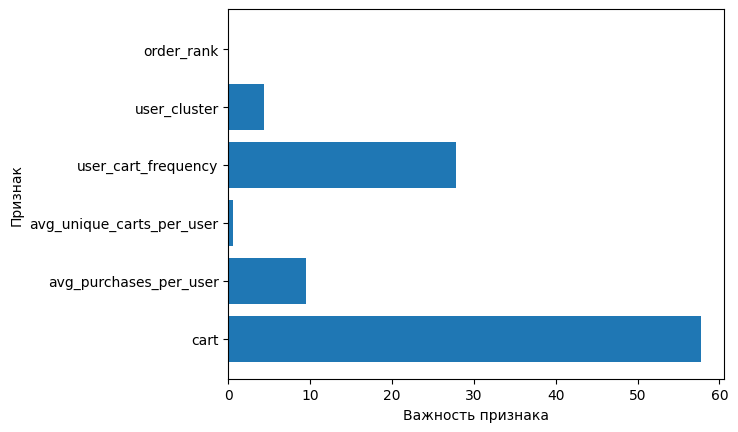

In [227]:
feature_names = X_train.columns
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()


In [228]:
# Предсказание классов для тестового набора данных
predictions = model.predict(X_test)

# Для расчета вероятностей принадлежности к классам (если это необходимо)
probabilities = model.predict_proba(X_test)[:, 1]

# Затем вы можете вычислить любые метрики на основе этих предсказаний, например, F1-меру, точность, полноту и т.д.


In [229]:
# Расчет F1-меры
f1 = f1_score(y_test, predictions)
# Расчет точности
precision = precision_score(y_test, predictions)
# Расчет полноты
recall = recall_score(y_test, predictions)
# Расчет AUC-ROC
auc_roc = roc_auc_score(y_test, probabilities)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")

F1 Score: 0.879604018423081
Precision: 0.8782087486579861
Recall: 0.8810037287625153
AUC-ROC: 0.9480836712765706


#### Формируем наш тестовый датасет с предсказанными данными

In [230]:
sample

,id,target,user_id,cart
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14
...,...,...,...,...
790444,19998;26,0,19998,26
790445,19998;31,0,19998,31
790446,19998;29,1,19998,29
790447,19998;798,1,19998,798


In [231]:
sample_with_predictions = sample_with_predictions.drop(['id','target'], axis = 1)

In [232]:
data.user_cluster.value_counts()

user_cluster
13    1357369
2     1283579
11     957568
1      745482
7      471361
12     392264
6      302526
3      227469
4      140447
10     132528
8       83384
9       80795
0       35311
14      28792
5        7253
Name: count, dtype: int64

In [233]:
# # Удаляем дубликаты из правой таблицы
# data_unique = data.drop_duplicates(subset=['user_id', 'cart'], keep='first')

# # Объединяем таблицы
# extended_predictions = pd.merge(sample_with_predictions, data_unique[['user_id', 'cart', 'avg_purchases_per_user', 'avg_unique_carts_per_user', 'total_purchases_per_cart', 'user_cart_frequency', 'user_cluster', 'order_rank']], on=['user_id', 'cart'], how='left')

# # Проверяем, что количество строк в объединенной таблице равно количеству строк в левой таблице
# print(len(extended_predictions) == len(sample_with_predictions))


In [234]:
# Удаляем дубликаты из правой таблицы по уникальным парам 'user_id' и 'cart'
data_unique = data.drop_duplicates(subset=['user_id', 'cart'], keep='first')

sample_with_predictions['user_id'] = sample_with_predictions['user_id'].astype(str)
data_unique['user_id'] = data_unique['user_id'].astype(str)

sample_with_predictions['cart'] = sample_with_predictions['cart'].astype(str)
data_unique['cart'] = data_unique['cart'].astype(str)

# После преобразования типов данных можно безопасно выполнять объединение
extended_data = pd.merge(sample_with_predictions, data_unique[['user_id', 'cart', 'avg_purchases_per_user',
                                                                'avg_unique_carts_per_user', 'user_cart_frequency', 
                                                                'order_rank']], 
                         on=['user_id', 'cart'], how='left')



# Проверяем, что количество строк в объединенной таблице соответствует количеству строк в левой таблице
print(len(extended_predictions) == len(sample_with_predictions))


/var/folders/gp/np_mqm314xqggrjr1y0zxzsw0000gn/T/ipykernel_64763/531045293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['user_id'] = data_unique['user_id'].astype(str)
/var/folders/gp/np_mqm314xqggrjr1y0zxzsw0000gn/T/ipykernel_64763/531045293.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['cart'] = data_unique['cart'].astype(str)


True


In [235]:
features_for_clustering = ['avg_purchases_per_user', 'avg_unique_carts_per_user', 'user_cart_frequency']
X_clustering = extended_data[features_for_clustering]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Кластеризация
kmeans = KMeans(n_clusters=15, random_state=3146)
extended_data['user_cluster'] = kmeans.fit_predict(X_scaled).astype(str)

# Теперь extended_data содержит новый категориальный столбец 'user_cluster', готовый к использованию в предсказаниях


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [236]:
extended_predictions

,user_id,cart,predicted_next_order_date,avg_purchases_per_user,avg_unique_carts_per_user,user_cart_frequency,user_cluster,order_rank
0,0,133,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.665094
1,0,5,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.665094
2,0,10,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.665094
3,0,396,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.665094
4,0,14,2020-09-04 07:59:12,0.011698,0.084296,0.005128,4,0.330189
...,...,...,...,...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,0.330189
790445,19998,31,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,0.330189
790446,19998,29,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,0.330189
790447,19998,798,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,1.000000


In [237]:
extended_predictions.user_cluster.value_counts

<bound method IndexOpsMixin.value_counts of 0         4
1         4
2         4
3         4
4         4
         ..
790444    4
790445    4
790446    4
790447    4
790448    4
Name: user_cluster, Length: 790449, dtype: object>

In [238]:

# extended_predictions['predicted_next_order_date'] = pd.to_datetime(extended_predictions['predicted_next_order_date'])

# extended_predictions['day_of_week'] = extended_predictions['predicted_next_order_date'].dt.dayofweek.astype(str)

# day_of_week_dummies = pd.get_dummies(extended_predictions['day_of_week'], prefix='day_of_week')

# # Объединяем оригинальный DataFrame с новыми бинарными признаками
# extended_predictions = pd.concat([extended_predictions, day_of_week_dummies], axis=1)

# # Удаляем оригинальные столбцы даты и категориальных признаков, если они больше не нужны
# extended_predictions.drop(['day_of_week'], axis=1, inplace=True)

# # Проверяем результат
# print(extended_predictions.head())


In [239]:
extended_predictions.columns

Index(['user_id', 'cart', 'predicted_next_order_date',
       'avg_purchases_per_user', 'avg_unique_carts_per_user',
       'user_cart_frequency', 'user_cluster', 'order_rank'],
      dtype='object')

In [242]:
# Названия столбцов для масштабирования, включая дату и новые признаки
columns_to_scale = [
       'avg_purchases_per_user', 'avg_unique_carts_per_user',
        'user_cart_frequency',
       'order_rank']

# Создание и обучение масштабировщика
scaler = MinMaxScaler()

# Правильно масштабируем столбцы в extended_predictions
extended_predictions[columns_to_scale] = scaler.fit_transform(extended_predictions[columns_to_scale])

# Проверка результатов
print(extended_predictions)


       user_id cart predicted_next_order_date  avg_purchases_per_user  \
0            0  133       2020-09-04 07:59:12                0.011698   
1            0    5       2020-09-04 07:59:12                0.011698   
2            0   10       2020-09-04 07:59:12                0.011698   
3            0  396       2020-09-04 07:59:12                0.011698   
4            0   14       2020-09-04 07:59:12                0.011698   
...        ...  ...                       ...                     ...   
790444   19998   26       2020-09-03 16:54:54                0.004565   
790445   19998   31       2020-09-03 16:54:54                0.004565   
790446   19998   29       2020-09-03 16:54:54                0.004565   
790447   19998  798       2020-09-03 16:54:54                0.004565   
790448   19998  415       2020-09-03 16:54:54                0.004565   

        avg_unique_carts_per_user  user_cart_frequency user_cluster  \
0                        0.084296             0.0000

In [244]:
X_for_prediction = extended_predictions.drop(['predicted_next_order_date', 'user_id'], axis=1)


In [245]:
X_for_prediction

,cart,avg_purchases_per_user,avg_unique_carts_per_user,user_cart_frequency,user_cluster,order_rank
0,133,0.011698,0.084296,0.000000,4,0.664875
1,5,0.011698,0.084296,0.000000,4,0.664875
2,10,0.011698,0.084296,0.000000,4,0.664875
3,396,0.011698,0.084296,0.000000,4,0.664875
4,14,0.011698,0.084296,0.007353,4,0.329749
...,...,...,...,...,...,...
790444,26,0.004565,0.032333,0.000000,4,0.329749
790445,31,0.004565,0.032333,0.000000,4,0.329749
790446,29,0.004565,0.032333,0.000000,4,0.329749
790447,798,0.004565,0.032333,0.000000,4,1.000000


In [246]:
# Получение предсказаний
predictions = model.predict(X_for_prediction)


In [247]:
len(predictions)

790449

In [248]:
sample['target'] = predictions

In [249]:
sample.target = sample.target.astype(int)

In [250]:
# Сохраняем обновленную таблицу sample в файл CSV (без индекса)
sample.to_csv('sample.csv', index=False)

In [251]:
# Добавление предсказаний обратно в extended_predictions для анализа или сохранения
extended_predictions['predicted_target'] = predictions

In [252]:
extended_predictions.predicted_target.value_counts()

predicted_target
1.0    589125
0.0    201324
Name: count, dtype: int64

In [253]:
extended_predictions

,user_id,cart,predicted_next_order_date,avg_purchases_per_user,avg_unique_carts_per_user,user_cart_frequency,user_cluster,order_rank,predicted_target
0,0,133,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.664875,0.0
1,0,5,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.664875,1.0
2,0,10,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.664875,1.0
3,0,396,2020-09-04 07:59:12,0.011698,0.084296,0.000000,4,0.664875,1.0
4,0,14,2020-09-04 07:59:12,0.011698,0.084296,0.007353,4,0.329749,1.0
...,...,...,...,...,...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,0.329749,1.0
790445,19998,31,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,0.329749,1.0
790446,19998,29,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,0.329749,1.0
790447,19998,798,2020-09-03 16:54:54,0.004565,0.032333,0.000000,4,1.000000,1.0


In [254]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,57,14,0.519933,0.448683,0.268455,0.516326,1.150757,0.035169,1.139851,0.272893
1,14,57,0.448683,0.519933,0.268455,0.598316,1.150757,0.035169,1.195138,0.237626
2,61,14,0.437156,0.448683,0.229774,0.525611,1.171452,0.033629,1.162161,0.260033
3,14,61,0.448683,0.437156,0.229774,0.512107,1.171452,0.033629,1.153622,0.265470
4,398,14,0.390123,0.448683,0.216785,0.555683,1.238475,0.041743,1.240819,0.315728
5,14,398,0.448683,0.390123,0.216785,0.483157,1.238475,0.041743,1.180006,0.349265
6,57,22,0.519933,0.327011,0.219793,0.422734,1.292722,0.049770,1.165822,0.471681
7,22,57,0.327011,0.519933,0.219793,0.672128,1.292722,0.049770,1.464193,0.336467
8,57,23,0.519933,0.343051,0.216116,0.415662,1.211661,0.037753,1.124261,0.363879
9,23,57,0.343051,0.519933,0.216116,0.629982,1.211661,0.037753,1.297416,0.265906


In [255]:
extended_predictions.columns

Index(['user_id', 'cart', 'predicted_next_order_date',
       'avg_purchases_per_user', 'avg_unique_carts_per_user',
       'user_cart_frequency', 'user_cluster', 'order_rank',
       'predicted_target'],
      dtype='object')

In [256]:
extended_predictions = extended_predictions[['user_id', 'cart', 'predicted_next_order_date', 'predicted_target']]


In [257]:
extended_predictions

,user_id,cart,predicted_next_order_date,predicted_target
0,0,133,2020-09-04 07:59:12,0.0
1,0,5,2020-09-04 07:59:12,1.0
2,0,10,2020-09-04 07:59:12,1.0
3,0,396,2020-09-04 07:59:12,1.0
4,0,14,2020-09-04 07:59:12,1.0
...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,1.0
790445,19998,31,2020-09-03 16:54:54,1.0
790446,19998,29,2020-09-03 16:54:54,1.0
790447,19998,798,2020-09-03 16:54:54,1.0


In [258]:

# # Сохраняем обновленную таблицу sample в файл CSV (без индекса)
# merged.to_csv('pred.csv', index=False)

добавим несколько едениц согласно правилам, которые выделили ранее, про товары, которые часто идут вместе

In [259]:
def add_recommended_items(group):
    # Получение списка товаров в текущем заказе
    items_in_order = set(group['cart'])
    # Список для хранения новых строк
    new_rows = []
    # Поиск правил, где antecedent присутствует в заказе
    applicable_rules = rules[rules['antecedents'].apply(lambda x: x in items_in_order)]
    for _, rule in applicable_rules.iterrows():
        consequent = rule['consequents']
        # Добавление новой строки, если consequent отсутствует в заказе
        if consequent not in items_in_order:
            new_row = group.iloc[0].copy()
            new_row['cart'] = consequent
            new_row['predicted_target'] = 1
            new_rows.append(new_row)
    # Возвращение новых строк в виде DataFrame
    return pd.DataFrame(new_rows)

# Применение функции к каждой группе и создание списка DataFrame'ов с новыми строками
new_rows_list = extended_predictions.groupby(['user_id', 'predicted_next_order_date']).apply(add_recommended_items).reset_index(drop=True)

# Объединение новых строк с исходным датасетом
final_extended = pd.concat([extended_predictions, new_rows_list], ignore_index=True)


In [260]:
final_extended

,user_id,cart,predicted_next_order_date,predicted_target
0,0,133,2020-09-04 07:59:12,0.0
1,0,5,2020-09-04 07:59:12,1.0
2,0,10,2020-09-04 07:59:12,1.0
3,0,396,2020-09-04 07:59:12,1.0
4,0,14,2020-09-04 07:59:12,1.0
...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,1.0
790445,19998,31,2020-09-03 16:54:54,1.0
790446,19998,29,2020-09-03 16:54:54,1.0
790447,19998,798,2020-09-03 16:54:54,1.0


In [261]:
final_extended.predicted_target.value_counts()

predicted_target
1.0    589125
0.0    201324
Name: count, dtype: int64

In [262]:
# Получаем список категорий, которые составляют нижние 80% по количеству
bottom_80_categories = bottom_80_categories_last_half_year['cart'].tolist()

# Добавляем новый столбец, который показывает, принадлежит ли товар к нижним 80% категорий
final_extended['bottom_80_categories_last_half_year'] = final_extended['cart'].isin(bottom_80_categories)

# Устанавливаем predicted_target в 0 для всех записей, где cart принадлежит к нижним 80% категорий
final_extended.loc[final_extended['bottom_80_categories_last_half_year'], 'predicted_target'] = 0

# Убираем вспомогательный столбец, если он вам больше не нужен
final_extended.drop('bottom_80_categories_last_half_year', axis=1, inplace=True)


In [263]:
final_extended.predicted_target.value_counts()

predicted_target
1.0    589125
0.0    201324
Name: count, dtype: int64

In [264]:
sample = sample.drop(['target'],axis=1)

In [265]:
sample

,id,user_id,cart
0,0;133,0,133
1,0;5,0,5
2,0;10,0,10
3,0;396,0,396
4,0;14,0,14
...,...,...,...
790444,19998;26,19998,26
790445,19998;31,19998,31
790446,19998;29,19998,29
790447,19998;798,19998,798


In [266]:
final_extended

,user_id,cart,predicted_next_order_date,predicted_target
0,0,133,2020-09-04 07:59:12,0.0
1,0,5,2020-09-04 07:59:12,1.0
2,0,10,2020-09-04 07:59:12,1.0
3,0,396,2020-09-04 07:59:12,1.0
4,0,14,2020-09-04 07:59:12,1.0
...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,1.0
790445,19998,31,2020-09-03 16:54:54,1.0
790446,19998,29,2020-09-03 16:54:54,1.0
790447,19998,798,2020-09-03 16:54:54,1.0


In [267]:
sample[['user_id', 'cart']] = sample['id'].str.split(';', expand=True)

In [268]:
final_extended.drop_duplicates(subset=['user_id', 'cart'], inplace=True)

In [269]:
sample

,id,user_id,cart
0,0;133,0,133
1,0;5,0,5
2,0;10,0,10
3,0;396,0,396
4,0;14,0,14
...,...,...,...
790444,19998;26,19998,26
790445,19998;31,19998,31
790446,19998;29,19998,29
790447,19998;798,19998,798


In [270]:
final_extended

,user_id,cart,predicted_next_order_date,predicted_target
0,0,133,2020-09-04 07:59:12,0.0
1,0,5,2020-09-04 07:59:12,1.0
2,0,10,2020-09-04 07:59:12,1.0
3,0,396,2020-09-04 07:59:12,1.0
4,0,14,2020-09-04 07:59:12,1.0
...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,1.0
790445,19998,31,2020-09-03 16:54:54,1.0
790446,19998,29,2020-09-03 16:54:54,1.0
790447,19998,798,2020-09-03 16:54:54,1.0


In [271]:
# Преобразование типов данных и объединение столбцов user_id и cart в один столбец id
final_extended['user_id'] = final_extended['user_id'].astype(int)
final_extended['cart'] = final_extended['cart'].astype(int)
#final_extended['id'] = final_extended['user_id'].astype(str) + ';' + final_extended['cart'].astype(str)

In [272]:
sample

,id,user_id,cart
0,0;133,0,133
1,0;5,0,5
2,0;10,0,10
3,0;396,0,396
4,0;14,0,14
...,...,...,...
790444,19998;26,19998,26
790445,19998;31,19998,31
790446,19998;29,19998,29
790447,19998;798,19998,798


In [273]:
# Создание столбца merge_key в final_extended
final_extended['merge_key'] = final_extended['user_id'].astype(str) + ';' + final_extended['cart'].astype(str)

# Создание столбца merge_key в sample (если он еще не создан)
sample['merge_key'] = sample['user_id'].astype(str) + ';' + sample['cart'].astype(str)

# Выполнение слияния
# Используем слияние типа 'right' для того, чтобы в результате были только строки из sample
merged_df = pd.merge(final_extended, sample, on='merge_key', how='right')

# После слияния, возможно, у вас появятся дубликаты столбцов (например, user_id_x, user_id_y). 
# Вы можете удалить лишние столбцы или переименовать их в соответствии с вашими потребностями:
merged_df.drop(columns=['user_id_y', 'cart_y'], inplace=True)  # Удаление дубликатов столбцов
merged_df.rename(columns={'user_id_x': 'user_id', 'cart_x': 'cart'}, inplace=True)  # Переименование оставшихся столбцов

# Убедитесь, что в итоговом DataFrame 790449 строк
print(merged_df.shape)


(790449, 6)


In [274]:
merged_df

,user_id,cart,predicted_next_order_date,predicted_target,merge_key,id
0,0,133,2020-09-04 07:59:12,0.0,0;133,0;133
1,0,5,2020-09-04 07:59:12,1.0,0;5,0;5
2,0,10,2020-09-04 07:59:12,1.0,0;10,0;10
3,0,396,2020-09-04 07:59:12,1.0,0;396,0;396
4,0,14,2020-09-04 07:59:12,1.0,0;14,0;14
...,...,...,...,...,...,...
790444,19998,26,2020-09-03 16:54:54,1.0,19998;26,19998;26
790445,19998,31,2020-09-03 16:54:54,1.0,19998;31,19998;31
790446,19998,29,2020-09-03 16:54:54,1.0,19998;29,19998;29
790447,19998,798,2020-09-03 16:54:54,1.0,19998;798,19998;798


In [275]:
#merged.target.value_counts()

In [276]:
merged_df.predicted_target.value_counts()

predicted_target
1.0    589125
0.0    201324
Name: count, dtype: int64

In [277]:
# Создание нового DataFrame с требуемыми столбцами
final_table = merged_df[['id', 'predicted_target']].copy()

# Переименование столбца для соответствия заданию
final_table.rename(columns={'predicted_target': 'target'}, inplace=True)

# Проверка результатов
print(final_table.head())


      id  target
0  0;133     0.0
1    0;5     1.0
2   0;10     1.0
3  0;396     1.0
4   0;14     1.0


In [278]:
final_table.target = final_table.target.astype(int)

In [279]:
final_table.target.value_counts()

target
1    589125
0    201324
Name: count, dtype: int64

In [281]:
# Сохраняем обновленную таблицу sample в файл CSV (без индекса)
final_table.to_csv('merged8.csv', index=False)